# Predicting non-functional water pumps in Tanzania, Part II

This is Part II of a project for a competition from [drivendata.org.](https://www.drivendata.org/competitions/7/)  
See: [Part I](https://github.com/JoomiK/PredictingWaterPumps/blob/master/WaterPumps.ipynb).  

Using data on water pumps in communities across Tanzania, can we predict the pumps that are functional, need repairs, or don't work at all?

The dataset contains a mix of continuous and categorical variables about what kind of pump is operating, when it was installed, how it was managed, etc. 

### Outline:  
Part I- EDA and cleanup
* The data  
* Visualizing water pumps and regions
* Dropping some features  
* Preprocessing labels  
* Looking at features  

Part II- Modeling
* Model selection and evaluation

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import sys
from scipy.stats import randint as sp_randint
import sklearn as sk
from sklearn import metrics, decomposition
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.model.metrics_base import H2OBinomialModelMetrics
import os

rcParams['figure.figsize'] = 12, 4
print('Python version: %s.%s.%s' % sys.version_info[:3])
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)

Python version: 3.5.2
numpy version: 1.11.1
pandas version: 0.18.1
scikit-learn version: 0.18.1


### The data

This dataset originally had 39 features. They are described [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list).  


In Part I of this analysis, I added some features, and used one-hot encoding to convert categorical varibales to dummy/indicator variables. This led to over 7000 features.

I will try modeling two ways: (1) on one-hot encoded data, with and without dimensionality reduction, and (2) on the original data without one-hot encoding.

In [26]:
# Load the one-hot encoded data
data = pd.read_csv('merged_clean_dum.csv', index_col='id')
data.head()

,amount_tsh,gps_height,num_private,region_code,district_code,population,construction_year,status_group,missing_construction_year,funder_0,...,waterpoint_type_improved spring,waterpoint_type_other,waterpoint_type_nan,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,waterpoint_type_group_nan
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,1390,0,11,5,109,1999.0,2,False,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8776,0.0,1399,0,20,2,280,2010.0,2,False,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
34310,25.0,686,0,21,4,250,2009.0,2,False,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
67743,0.0,263,0,90,63,58,1986.0,0,False,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19728,0.0,0,0,18,1,0,NaN,2,True,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [27]:
print("Data rows, columns:",data.shape)

Data rows, columns: (59400, 7069)


Note: region_code and district_code are integers, but categorical. I could convert these to dummy variables too, but I will leave these as is for the first pass.

In [55]:
# Getting just the features by dropping the labels
train = data.drop('status_group',1)

# Getting labels
labels = data.status_group

### Model preprocessing and selection

In [58]:
X = train.as_matrix()
y = labels.tolist()

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

#### I. GridSearchCV w/the one-hot encoded data
Imputation, dimensionality reduction, and selection of hyperparameters for a random forest classifier (Note- I'm not testing hyperparameters exhaustively for now):

In [66]:
imputer = Imputer(strategy='median')
pca = decomposition.PCA()
rf = RandomForestClassifier(class_weight='balanced', 
                            n_jobs=-1, 
                            n_estimators=300)

steps = [('imputer', imputer),
        ('pca', pca),
        ('random_forest', rf)]

pipeline = Pipeline(steps)
parameters = dict(
                pca__n_components=[40, 100, 300], 
                random_forest__max_features=['auto', 'log2']
                )

gs = GridSearchCV(pipeline, param_grid=parameters)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight=..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'random_forest__max_features': ['auto', 'log2'], 'pca__n_components': [40, 100, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [67]:
print(gs.best_score_)
print(gs.best_params_)

0.773400673401
{'random_forest__max_features': 'log2', 'pca__n_components': 100}


#### Classification report
The model has an f1-score of about 0.8 for labels 0 and 2 (non-functional and functional), but does poorly on label 1- functional but needs repairs.

In [69]:
rf = gs.best_estimator_
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.76      0.79      6875
          1       0.41      0.39      0.40      1333
          2       0.80      0.85      0.82      9612

avg / total       0.78      0.78      0.78     17820



#### Steps
1. Median imputation  
2. PCA with n_components=100  
3. Random Forest w/max_features=log2  
(Note: I could refine hyperparameters further but I'll move ahead for now). 

In [82]:
rf.steps

[('imputer',
  Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)),
 ('pca',
  PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('random_forest',
  RandomForestClassifier(bootstrap=True, class_weight='balanced',
              criterion='gini', max_depth=None, max_features='log2',
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False))]

In [75]:
rf.steps[2][1]

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [77]:
importances = rf.steps[2][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.steps[2][1].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [78]:
feature_names = np.array(list(train.columns.values))
feature_names

array(['amount_tsh', 'gps_height', 'num_private', ...,
       'waterpoint_type_group_improved spring',
       'waterpoint_type_group_other', 'waterpoint_type_group_nan'], 
      dtype='<U58')

In [79]:
important_names = feature_names[importances>np.mean(importances)]
print(important_names)

['amount_tsh' 'gps_height' 'region_code' 'district_code' 'population'
 'construction_year' 'missing_construction_year' 'funder_0'
 'funder_A/co Germany' 'funder_Aar' 'funder_Abas Ka' 'funder_Abasia'
 'funder_Abc-ihushi Development Cent' 'funder_Abd' 'funder_Abdala'
 'funder_Abood' 'funder_Abs' 'funder_Aco/germany' 'funder_Acord Ngo'
 'funder_Act' 'funder_Act Mara' 'funder_Africa Project Ev Germany'
 'funder_Africaone Ltd' 'funder_Aqua Blues Angels' 'funder_Area']


/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 7068 but corresponding boolean dimension is 100
  if __name__ == '__main__':


#### Top features

Some of the top features are: amount_tsh (total static head, or amount water available to waterpoint), gps_height (altitude of the well), region and district codes, population, construction year, missing construction year, and funder.

#### Some caveats:  
This is not unique to using random forests for feature selection, but applies to most model based feature selection methods: if the dataset has correlated features, once one of them is used as a predictor, the importance of the others is significantly reduced. This is ok if we just want to use feature selection to avoid overfitting, but if we are using it to interpret the data, we have to be careful. 

#### Problems with one-hot encoding:
When we one-hot encoded categorical variables, the resulting sparsity makes continuous variables assigned higher feature importance. Moreover, a single level of a categorical variable must meet a very high bar to be selected for splitting early in the tree building, which can degrade predictive performance. Lastly, by one-hot encoding, we created many binary variables, and they were all seen as independent (from the splitting algorithm's point of view). 

#### Confusion matrix

In [80]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat

array([[5216,  217, 1442],
       [ 211,  523,  599],
       [ 911,  539, 8162]])

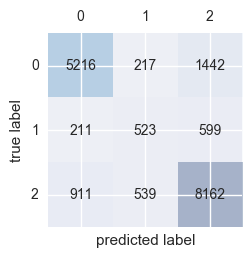

In [81]:
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,
               s=confmat[i,j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

The model has the most trouble classifying water pumps in class 1 (pumps that need repair).

#### II. H2O implementation of random forest without one-hot encoding

The H2O random forest implementation lets you input categorical data without one-hot encoding. It also treats missing values differently than sklearn's (as a separate category).

Start up a local H2O cluster:

In [4]:
h2o.init(max_mem_size = "2G", nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_40"; Java(TM) SE Runtime Environment (build 1.8.0_40-b27); Java HotSpot(TM) 64-Bit Server VM (build 25.40-b25, mixed mode)
  Starting server from /Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5d/ftxntrp16l5g04c049nr03pr0000gp/T/tmp_jb85xnp
  JVM stdout: /var/folders/5d/ftxntrp16l5g04c049nr03pr0000gp/T/tmp_jb85xnp/h2o_jkim_started_from_python.out
  JVM stderr: /var/folders/5d/ftxntrp16l5g04c049nr03pr0000gp/T/tmp_jb85xnp/h2o_jkim_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,2 months and 9 days
H2O cluster name:,H2O_from_python_jkim_cz0i75
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


#### Import data  
This is a cleaned up version of the data without one-hot encoding.

In [5]:
data2 = h2o.import_file(os.path.realpath('merged_clean.csv'))

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Encode response variable  
Since we want to train a classification mode, we must ensure that the response is coded as a factor.

In [6]:
data2['status_group']=data2['status_group'].asfactor() # encode response as a factor
data2['status_group'].levels() # show the levels

[['0', '1', '2']]

#### Partition data

In [7]:
# Partition data into 70%, 15%, 15% chunks
# Setting a seed will guarantee reproducibility
train, valid, test = data2.split_frame([0.7, 0.15], seed=1234)

In [8]:
X = data2.col_names[1:-1] # All columns except first (id) and last (reponse variable) 
y = data2.col_names[-1] # Response variable

#### Model

I'll quickly build a model for now and come back to tuning hyperparameters later. 

In [9]:
rf_v1 = H2ORandomForestEstimator(
        model_id="rf_v1",
        balance_classes=True,
        ntrees=300,
        stopping_rounds=2,
        score_each_iteration=True,
        seed=1000000)

In [10]:
rf_v1.train(X, y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [11]:
rf_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_v1
Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,32.0,96.0,3629520.0,20.0,20.0,20.0,1433.0,3759.0,2650.0938




ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.24663297395089073
RMSE: 0.496621560094697
LogLoss: 0.7351344533214206
Mean Per-Class Error: 0.34878276470320757
Confusion Matrix: vertical: actual; across: predicted



0,1,2,Error,Rate
17622.0,91.0,4808.0,0.2175303,"4,899 / 22,521"
3197.0,5680.0,13685.0,0.7482493,"16,882 / 22,562"
1683.0,136.0,20758.0,0.0805687,"1,819 / 22,577"
22502.0,5907.0,39251.0,0.3488028,"23,600 / 67,660"


Top-3 Hit Ratios: 


k,hit_ratio
1,0.6511971
2,0.8973396
3,0.9999999



ModelMetricsMultinomial: drf
** Reported on validation data. **

MSE: 0.1594342154717807
RMSE: 0.399292143012833
LogLoss: 0.54388162010831
Mean Per-Class Error: 0.39999447107732106
Confusion Matrix: vertical: actual; across: predicted



0,1,2,Error,Rate
2494.0,18.0,897.0,0.2684072,"915 / 3,409"
92.0,87.0,446.0,0.8608,538 / 625
325.0,16.0,4477.0,0.0707763,"341 / 4,818"
2911.0,121.0,5820.0,0.2026661,"1,794 / 8,852"


Top-3 Hit Ratios: 


k,hit_ratio
1,0.7973340
2,0.9536828
3,1.0


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
,2017-01-17 12:03:16,0.018 sec,0.0,nan,nan,nan,nan,nan,nan
,2017-01-17 12:03:18,2.216 sec,1.0,0.5951179,8.5421026,0.3883801,0.5236415,6.8440286,0.2817442
,2017-01-17 12:03:19,2.854 sec,2.0,0.5879322,8.0989405,0.3799788,0.4518493,3.2032095,0.2403977
,2017-01-17 12:03:20,3.387 sec,3.0,0.5767514,7.1878886,0.3760123,0.4255624,1.8792577,0.2220967
,2017-01-17 12:03:20,3.919 sec,4.0,0.5565996,5.8767437,0.3620462,0.4141192,1.2854569,0.2159964
---,---,---,---,---,---,---,---,---,---
,2017-01-17 12:03:32,15.659 sec,28.0,0.4966274,0.7603848,0.3469849,0.3994254,0.5534639,0.2005197
,2017-01-17 12:03:32,16.154 sec,29.0,0.4960718,0.7481101,0.3463494,0.3992440,0.5441000,0.2001808
,2017-01-17 12:03:33,16.635 sec,30.0,0.4969369,0.7459109,0.3492019,0.3996000,0.5445013,0.2021012
,2017-01-17 12:03:33,17.124 sec,31.0,0.4965813,0.7387624,0.3488915,0.3994825,0.5445578,0.2015364



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
lga,127887.0,1.0,0.1876133
quantity,62685.6757812,0.4901646,0.0919614
quantity_group,46434.4179688,0.3630894,0.0681204
region,36214.4062500,0.2831750,0.0531274
funder,33745.8203125,0.2638722,0.0495059
---,---,---,---
amount_tsh,4199.7519531,0.0328396,0.0061611
management_group,4159.1743164,0.0325223,0.0061016
source_class,3242.0720215,0.0253511,0.0047562
missing_construction_year,1844.0565186,0.0144194,0.0027053



See the whole table with table.as_data_frame()


Just like in the sklearn implementation, from looking at the confusion marix we can see that the error is highest with label 1. It does relatively well with labels 0 and 2. The hit_ratio is the ratio of the number of times a correct prediction was made, to the total number of predictions.

The top features are also different from what we saw with the sklearn implementation, which upweighted the importance of continuous variables. In the H2O implementation the top features are all categorical.